# **SHAP: Cómo interpretar modelos de machine learning con Python**

A nadie le gusta un modelo de caja negra. Con algoritmos sofisticados y una buena cantidad de preparación de datos, construir buenos modelos es fácil, pero ¿qué pasa dentro? Ahí es donde entran en juego Explainable AI y SHAP.

Hoy aprenderás a explicar los modelos de aprendizaje automático a la población en general. Utilizaremos tres gráficos diferentes para la interpretación: uno para una sola predicción, otro para una sola variable y otro para todo el conjunto de datos.

Después de este notebook, no deberías tener ningún problema para interpretar las predicciones del modelo de aprendizaje automático y la importancia de cada predictor.

## ¿Qué es SHAP?

Veamos una declaración oficial de sus creadores:

SHAP (SHapley Additive exPlanations) es un enfoque teórico de juegos para explicar el resultado de cualquier modelo de aprendizaje automático. Conecta la asignación óptima de créditos con explicaciones locales utilizando los valores de Shapley clásicos de la teoría de juegos y sus extensiones relacionadas.

Son muchas palabras que nos hacen parecer que sabemos mucho, pero esto es lo único que debes saber: SHAP nos ayuda a interpretar los modelos de aprendizaje automático con valores de Shapely.

Pero, ¿qué son los valores Shapely? En pocas palabras, son medidas de la contribución de cada predictor (característica) en un modelo de aprendizaje automático. Esta es la definición menos elegante, pero creo que es lo suficientemente fácil de entender.

Empecemos a entrenar nuestro modelo para poder empezar con la interpretación lo antes posible.

## Model training

Para interpretar un modelo de aprendizaje automático, primero necesitamos un modelo, así que vamos a crear uno basado en el conjunto de datos Calidad del vino. He aquí cómo cargarlo en Python:

In [1]:
import pandas as pd
wine = pd.read_csv('data/wine.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [2]:
wine['quality'] = wine['quality'].apply(lambda row: 0 if row <=5 else 1)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


No es necesario limpiar los datos: todos los tipos de datos son numéricos y no faltan datos. El siguiente paso es la división entre entrenamiento y prueba. La calidad de la columna es la variable objetivo, y puede ser buena o mala. Para obtener la misma división, establezca el valor de random_state en 73:

In [3]:
from sklearn.model_selection import train_test_split

X = wine.drop('quality', axis=1)
y = wine['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

Y ahora estamos listos para entrenar el modelo. El clasificador XGBoost hará el trabajo. Una vez más, el valor de random_state se establece en 73 para la reproducibilidad:

In [4]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=73)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

In [5]:
score

0.771875

fuera de la caja, tenemos una precisión del 77.5% (puntuación). Ahora tenemos todo lo que necesitamos para empezar a interpretar el modelo.

## Model interpretation

calcular los valores SHAP

In [6]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

## Explicar una única predicción

Empecemos por lo sencillo. Con SHAP, podemos generar explicaciones para una única predicción. El gráfico SHAP muestra las características que contribuyen a empujar la salida desde el valor base (salida media del modelo) hasta el valor real predicho.

El color rojo indica las características que aumentan la predicción, mientras que el azul indica justo lo contrario.

Veamos un gráfico de interpretación de un vino clasificado como malo:

In [7]:
X.iloc[0, :]

fixed acidity            7.4000
volatile acidity         0.7000
citric acid              0.0000
residual sugar           1.9000
chlorides                0.0760
free sulfur dioxide     11.0000
total sulfur dioxide    34.0000
density                  0.9978
pH                       3.5100
sulphates                0.5600
alcohol                  9.4000
Name: 0, dtype: float64

In [8]:
y.iloc[0]

np.int64(0)

In [9]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

Se trata de un conjunto de datos de clasificación, así que no hay que preocuparse demasiado por el valor f(x). los atributos total sulfur dioxide y citric acid junto con otros empujaron en este caso hacia una buena calidad del vino, pero no fue suficiente, como podemos ver.

A continuación, echemos un vistazo a la carta de interpretación de un buen vino:

In [10]:
shap.force_plot(explainer.expected_value, shap_values[3, :], X.iloc[3, :])

Esta es otra historia. Ahora que ya sabes cómo interpretar una sola predicción, vamos a darle un poco más de vidilla al asunto y veremos cómo interpretar el efecto de una sola característica en el resultado del modelo.

## Explicación de una característica

Para comprender el efecto que tiene una sola característica en el resultado del modelo, podemos representar gráficamente el valor SHAP de esa característica frente al valor de la característica para todas las instancias del conjunto de datos.

El gráfico siguiente muestra el cambio en la calidad del vino a medida que varía el valor del alcohol. Las dispersiones verticales en un único valor muestran los efectos de interacción con otras características. SHAP selecciona automáticamente otra característica para colorearla y facilitar la visualización de estas interacciones:

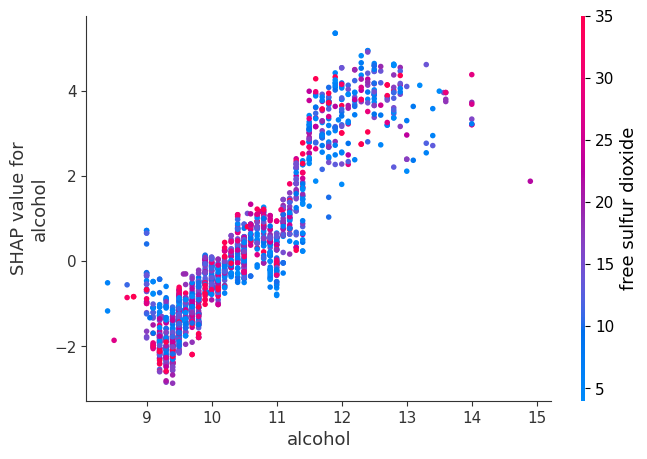

In [11]:
shap.dependence_plot('alcohol', shap_values, X)

Examinemos ahora todo el conjunto de datos para determinar qué características son las más importantes para el modelo y cómo contribuyen a las predicciones.

## Explicación del conjunto de datos

Podemos visualizar la importancia de las características y su impacto en la predicción trazando gráficos de resumen. El que se muestra a continuación ordena las características por la suma de las magnitudes de los valores SHAP en todas las muestras. También utiliza los valores SHAP para mostrar la distribución del impacto de cada característica.

El color representa el valor de la característica: el rojo indica alto y el azul, bajo. Veamos el gráfico a continuación:

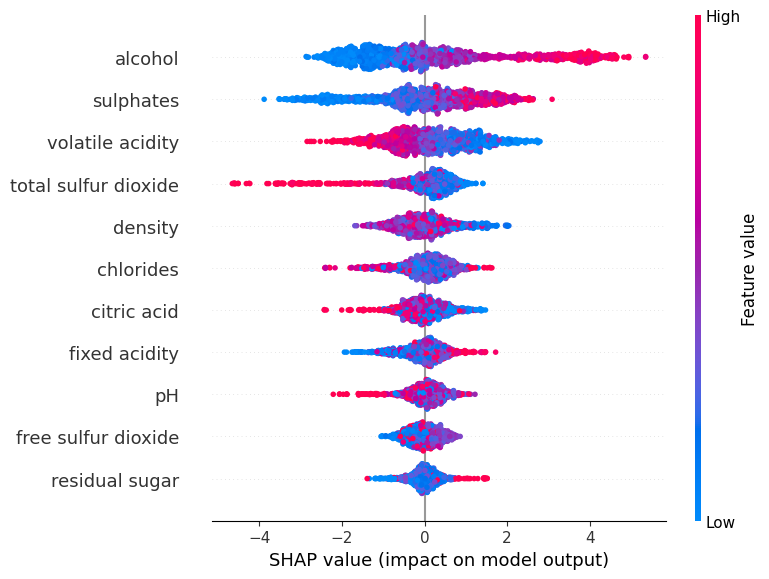

In [12]:
shap.summary_plot(shap_values, X)

Para interpretar:

- Un valor alcohólico elevado aumenta la calidad prevista del vino
- Una acidez volátil baja aumenta la calidad prevista del vino

Interpretar modelos de aprendizaje automático puede parecer complicado al principio, pero las bibliotecas como SHAP hacen que todo sea tan fácil como una llamada a una función. Incluso no tenemos que preocuparnos por la visualización de los datos, ya que hay funciones integradas para ello.